In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import gc
import itertools
from IPython.core.interactiveshell import InteractiveShell
import zipfile
import os

%matplotlib inline

In [2]:
# os.getcwd()

## Files: reading

There are 5 files associated with this project. They will be read directly from the zip file they are in.

In [3]:
zf = zipfile.ZipFile('competitive-data-science-predict-future-sales.zip') 

In [4]:
# Read items
items = pd.read_csv(zf.open('items.csv'))

# Read sales train
sales_train = pd.read_csv(zf.open('sales_train.csv'))
sales_train['date'] = pd.to_datetime(sales_train['date'], format= '%d.%m.%Y')
sales_train['revenue'] = sales_train['item_price']*sales_train['item_cnt_day']

# Read item categories
item_categories = pd.read_csv(zf.open('item_categories.csv'))

# Read shops
shops = pd.read_csv(zf.open('shops.csv'))

# Read test
test = pd.read_csv(zf.open('test.csv'))


## Files: schema

Files associated with this competition are presented on this order:
1. **Training data sets:**<br>
   1.1. sales_train<br>
   1.2. shops<br>
   1.3. items<br>
   1.4. item_category<br>
   
2. **Test data sets:**<br>
   2.1. test_train<br>
   2.2. sample submission<br>
  
A quick analysis of the tables' schema names raise the following questions:
  1. __Are all the features across the training sets reasonably feasible?__<br>
  2. __Is it a pricing model?__<br>
  3. __If so, what is the right approach to the training info?__<br>
     3.1 __Is a TSA approach the right one?__<br>
     3.2 __Is an optimization approach the right one?__<br>
     3.3 __or, a standard ML approach can provide a good answer, instead?__<br>
     
From our 1.0 Read Data file we found out that the language used on the features item_name, shop_name, and item_category_name is Russian.  We could translate some of it via "import googletrans", but it would take days given the 150 translations/day cap, meaning that getting those translation alone would take almost a month.  Therefore, only sales_train and items dataframes are necessary to create our initial train data set.

See the graphic below:


<img src="schema.png" width="600" height="600" align="center"/>

Our two data sets for test and sample submission introduce us to the features that will be used to predict (shop_id and item_id), as well as the target variable (item_cnt_month).  Notice that the target variable is NOT present in our train data sets.  Therefore, we are expected to aggregate our train feature item_cnt_day to create a similar target variable for analysis purposes.

A revenue feature was created given that prices and item quantities are present.

**Why do we mention that this would be a maximization problem?**

The target variable is a quantity and both quantity and price are part of our training data.  This means that the feature revenue must be included.

\begin{equation*}
\ Revenue = Price * Quantity  
\Longrightarrow
\ Quantity =
\frac{Revenue}{Price}
\end{equation*}



## Business Question

*What should it be the number of items sold per month given the store id and the item category purchased?*

## Exploratory Data Analysis

### Uniqueness analysis

From the analysis we can conclude that all items are not part of the original sales train set.

In [5]:
print('-'*50)
print('#'*8,'Uniqueness Analysis on Features', '#'*8)
print('-'*50)
print('Number of items in training data: ', ' '*8, len(items.item_id.unique()))
print('Number of item categories in training data: ', ' ', len(items.item_category_id.unique()))
print('Number of shops in training data: ', ' '*11,  len(sales_train.shop_id.unique()))
print('Number of items in test data: ', ' '*13,  len(test.item_id.unique()))
print('Number of shops in test data: ', ' '*15,  len(test.shop_id.unique()))

--------------------------------------------------
######## Uniqueness Analysis on Features ########
--------------------------------------------------
Number of items in training data:           22170
Number of item categories in training data:    84
Number of shops in training data:              60
Number of items in test data:                5100
Number of shops in test data:                  42


In [6]:
unique_items = sales_train.item_id.unique()
unique_shops = sales_train.shop_id.unique()

test_exclusive_items = test[~(test.item_id.isin(unique_items))]
test_exclusive_shops = test[~(test.shop_id.isin(unique_shops))]

print('-'*60)
print('#'*11,'Uniqueness Analysis on Test Features', '#'*11)
print('-'*60)
print('Number of items instances exclusive to the test set: ', test_exclusive_items.shape[0])
print('Number of unique items exclusive to the test set: ', ' '*4, len(test_exclusive_items.item_id.unique()))
print('Number of shops instances exclusive to the test set: ', ' '*3,  test_exclusive_shops.shape[0])
print('Number of unique shops exclusive to the test set:', ' '*7,  len(test_exclusive_shops.shop_id.unique()))

print('-'*60)
print('#'*11,'Analysis with Dimensional Data Sets', '#'*11)
print('-'*60)

unique_items = items.item_id.unique()
unique_shops = shops.shop_id.unique()

test_exclusive_items = test[~(test.item_id.isin(unique_items))]
test_exclusive_shops = test[~(test.shop_id.isin(unique_shops))]

print('Number of items instances exclusive to the test set: ',' '*3, test_exclusive_items.shape[0])
print('Number of unique items exclusive to the test set: ', ' '*6, len(test_exclusive_items.item_id.unique()))
print('Number of shops instances exclusive to the test set: ', ' '*3,  test_exclusive_shops.shape[0])
print('Number of unique shops exclusive to the test set:', ' '*7,  len(test_exclusive_shops.shop_id.unique()))

------------------------------------------------------------
########### Uniqueness Analysis on Test Features ###########
------------------------------------------------------------
Number of items instances exclusive to the test set:  15246
Number of unique items exclusive to the test set:       363
Number of shops instances exclusive to the test set:      0
Number of unique shops exclusive to the test set:         0
------------------------------------------------------------
########### Analysis with Dimensional Data Sets ###########
------------------------------------------------------------
Number of items instances exclusive to the test set:      0
Number of unique items exclusive to the test set:         0
Number of shops instances exclusive to the test set:      0
Number of unique shops exclusive to the test set:         0


In [7]:
unique_items_test = test.item_id.unique()
unique_shops_test = test.shop_id.unique()

train_exclusive_items = sales_train[~(sales_train.item_id.isin(unique_items_test))]
train_exclusive_shops = sales_train[~(sales_train.shop_id.isin(unique_shops_test))]

print('-'*63)
print('#'*12,'Uniqueness Analysis on Train Features', '#'*12)
print('-'*63)
print('Number of items instances exclusive to train test set: ', train_exclusive_items.shape[0])
print('Number of unique items exclusive to the train set: ', ' '*5, len(train_exclusive_items.item_id.unique()))
print('Number of shops instances exclusive to the train set:   ', train_exclusive_shops.shape[0])
print('Number of unique shops exclusive to the train set:', ' '*9,  len(train_exclusive_shops.shop_id.unique()))

print('-'*63)
print('#'*13,'Analysis with Dimensional Data Sets', '#'*13)
print('-'*63)

unique_items = items.item_id.unique()
unique_shops = shops.shop_id.unique()

train_exclusive_items = sales_train[~(sales_train.item_id.isin(unique_items))]
train_exclusive_shops = sales_train[~(sales_train.shop_id.isin(unique_shops))]

print('Number of items instances exclusive to the train set: ', ' '*6, train_exclusive_items.shape[0])
print('Number of unique items exclusive to the train set: ', ' '*9, len(train_exclusive_items.item_id.unique()))
print('Number of shops instances exclusive to the train set:  ', ' '*5, train_exclusive_shops.shape[0])
print('Number of unique shops exclusive to the train set:', ' '*10,  len(train_exclusive_shops.shop_id.unique()))

---------------------------------------------------------------
############ Uniqueness Analysis on Train Features ############
---------------------------------------------------------------
Number of items instances exclusive to train test set:  1489843
Number of unique items exclusive to the train set:        17070
Number of shops instances exclusive to the train set:    522603
Number of unique shops exclusive to the train set:           18
---------------------------------------------------------------
############# Analysis with Dimensional Data Sets #############
---------------------------------------------------------------
Number of items instances exclusive to the train set:         0
Number of unique items exclusive to the train set:            0
Number of shops instances exclusive to the train set:         0
Number of unique shops exclusive to the train set:            0


### Sales train analysis

### Graph date_block_num

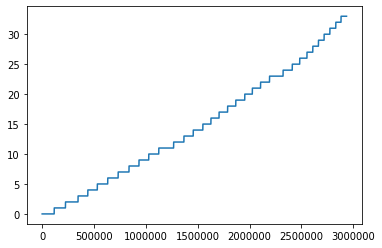

In [8]:
sales_train.date_block_num.plot()

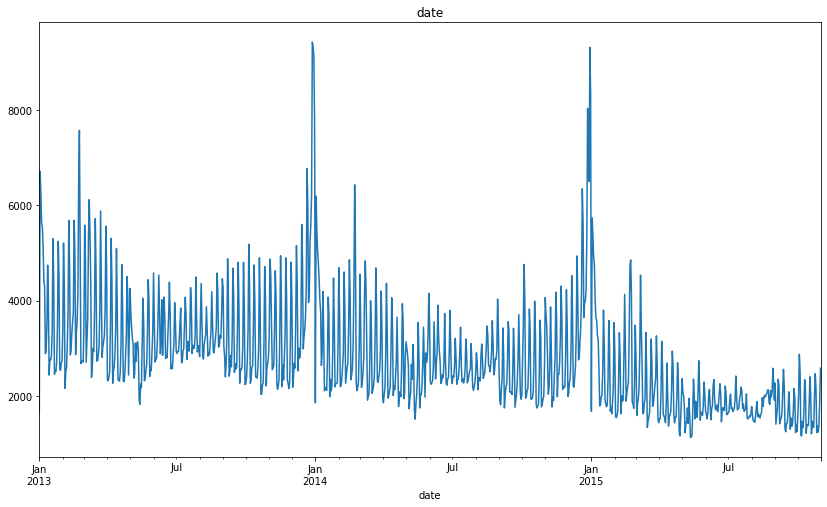

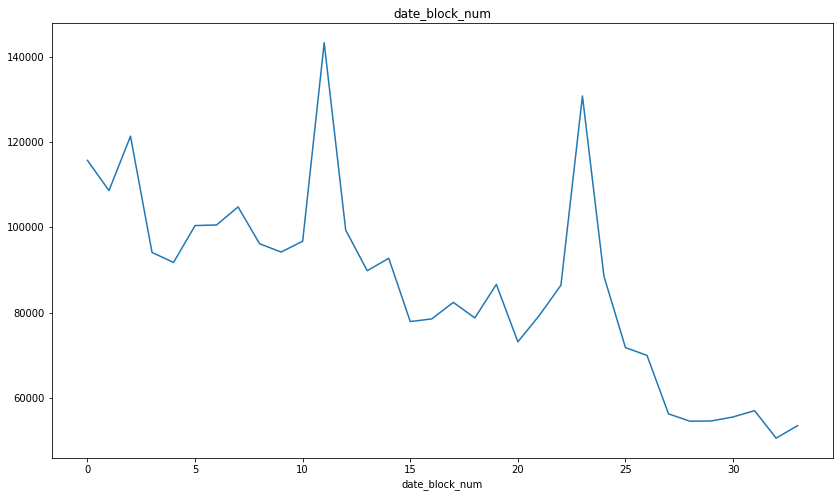

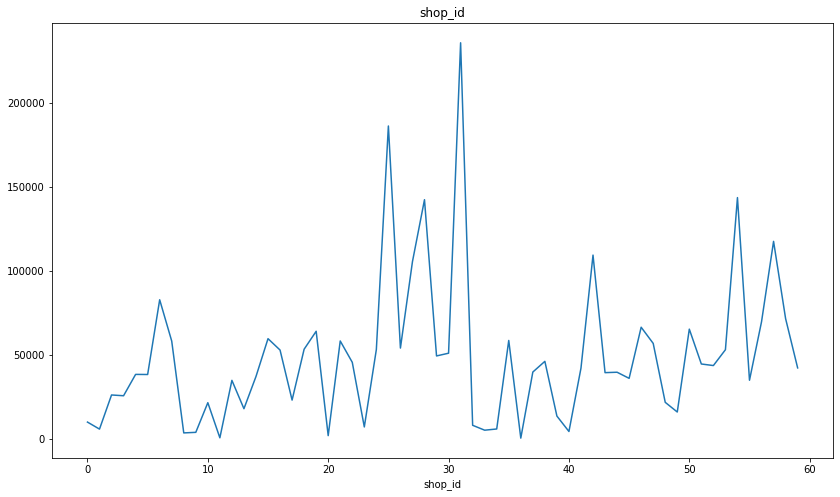

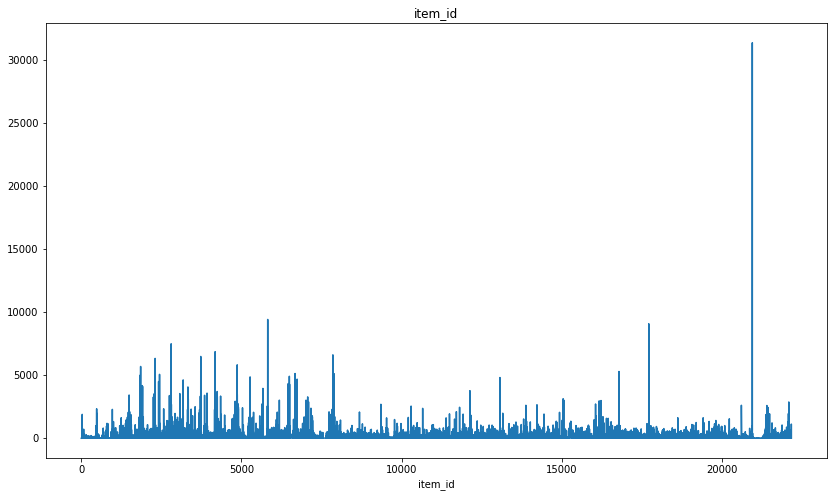

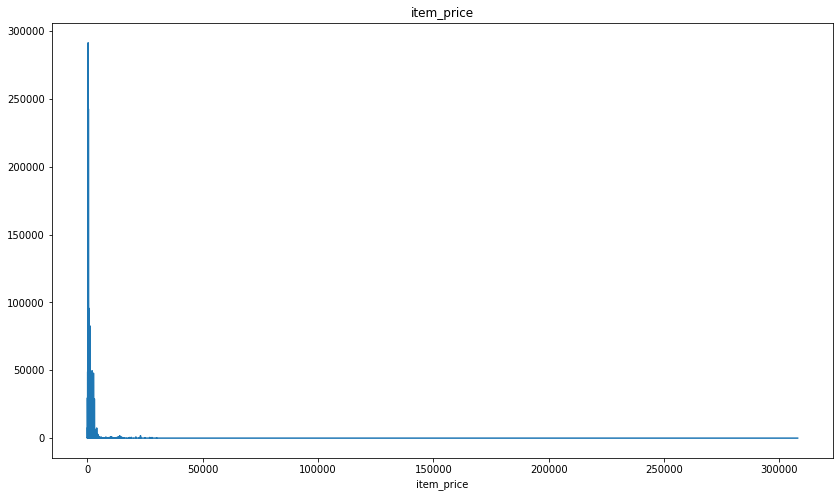

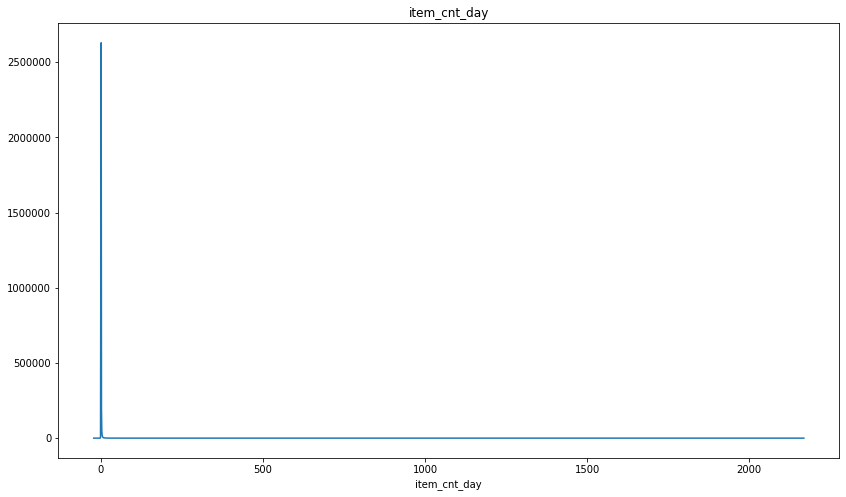

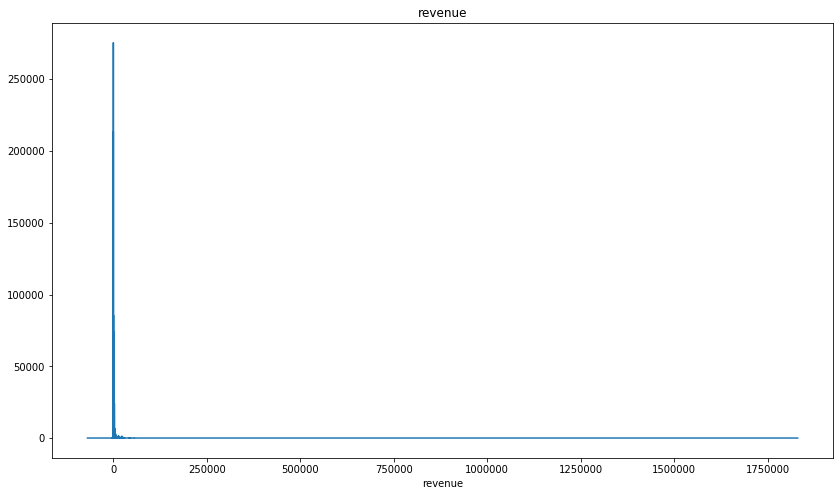

In [9]:
for i in sales_train.columns:
    sales_train.groupby(i).agg(date= (i, 'count')).plot(figsize= (14,8), title= i, legend= False);

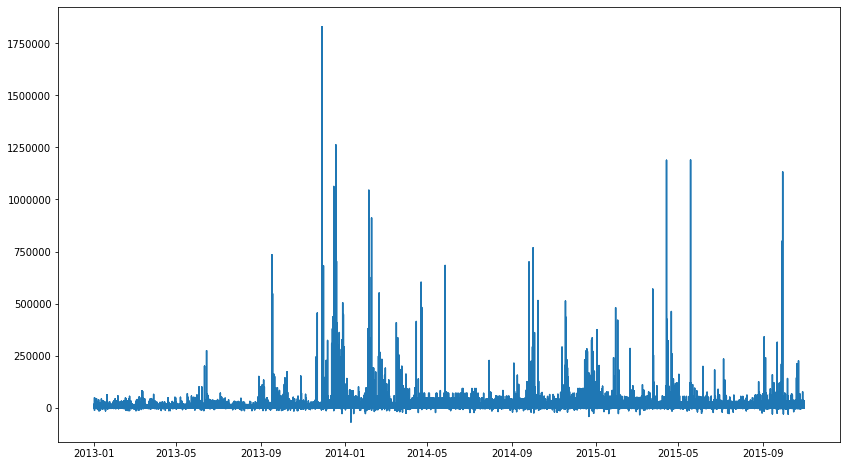

In [10]:
sales_train_ordered = sales_train.sort_values('date').copy()

fig, ax = plt.subplots(figsize= (14,8))
plt.plot(sales_train_ordered['date'], sales_train_ordered['revenue']);

In [11]:
sales_train_ordered

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
49800,2013-01-01,0,18,5823,2500.0,1.0,2500.0
29784,2013-01-01,0,27,5573,849.0,1.0,849.0
35476,2013-01-01,0,7,1006,399.0,1.0,399.0
8330,2013-01-01,0,19,17707,899.0,1.0,899.0
57384,2013-01-01,0,14,19548,149.0,1.0,149.0
...,...,...,...,...,...,...,...
2885098,2015-10-31,33,41,21386,169.0,1.0,169.0
2930981,2015-10-31,33,21,988,199.0,1.0,199.0
2885097,2015-10-31,33,41,21377,169.0,1.0,169.0
2930993,2015-10-31,33,22,10207,1199.0,1.0,1199.0


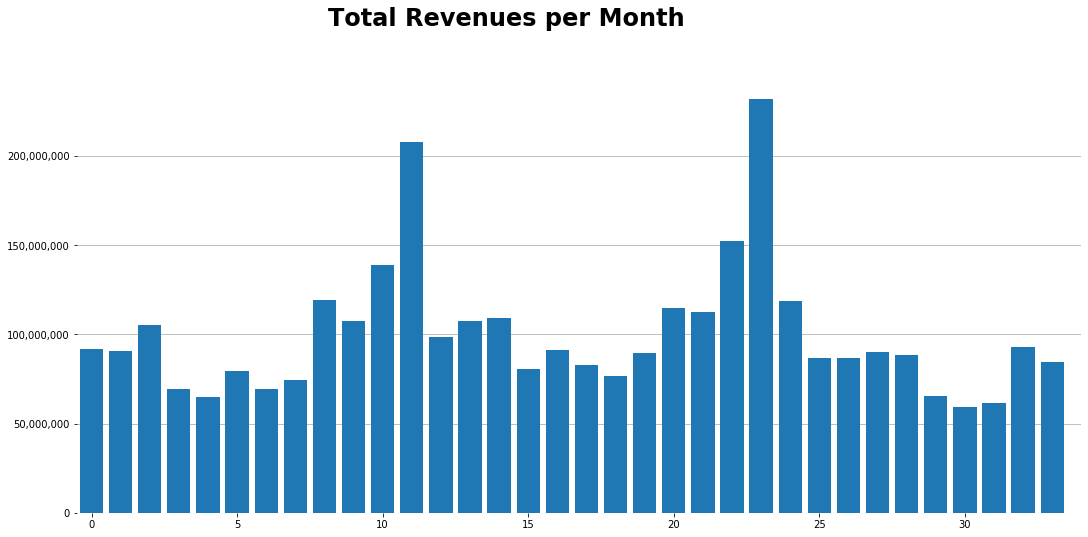

In [12]:
rev_agg = sales_train_ordered.groupby('date_block_num').agg(revenue= ('revenue','sum'))
fig,  ax = plt.subplots(figsize = (18,8))
ax.bar(rev_agg.index, rev_agg['revenue'], align='center')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.grid(which= 'major', axis= 'y', linestyle= '-')
ax.set_axisbelow(True)
plt.xlim(-0.5,34)
ax.text(0.25, 1.12, 'Total Revenues per Month',
        transform= ax.transAxes, size= 24, weight= 600, ha= 'left')
plt.box(False);

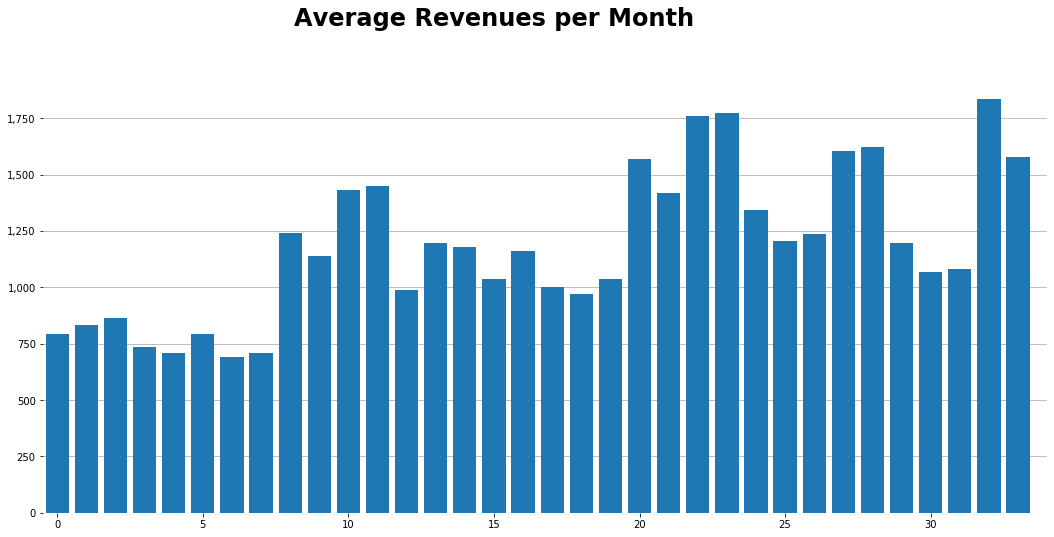

In [13]:
rev_agg = sales_train_ordered.groupby('date_block_num').agg(revenue= ('revenue','mean'))
fig,  ax = plt.subplots(figsize = (18,8))
ax.bar(rev_agg.index, rev_agg['revenue'], align='center')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.grid(which= 'major', axis= 'y', linestyle= '-')
ax.set_axisbelow(True)
plt.xlim(-0.5,34)
ax.text(0.25, 1.12, 'Average Revenues per Month',
        transform= ax.transAxes, size= 24, weight= 600, ha= 'left')
plt.box(False);

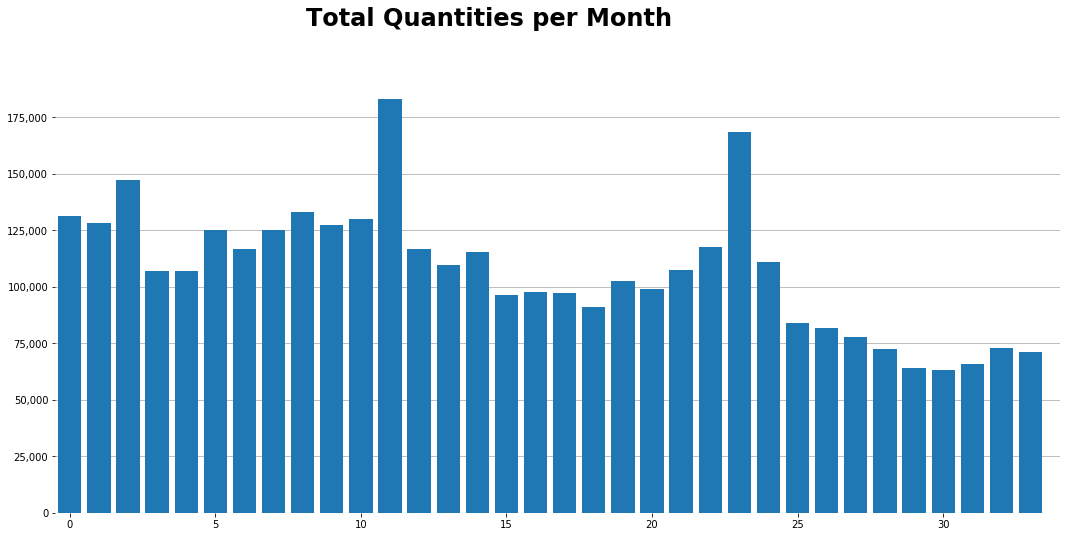

In [14]:
rev_agg = sales_train_ordered.groupby('date_block_num').agg(item_cnt_month = ('item_cnt_day','sum'))
fig,  ax = plt.subplots(figsize = (18,8))
ax.bar(rev_agg.index, rev_agg['item_cnt_month'], align='center')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.grid(which= 'major', axis= 'y', linestyle= '-')
ax.set_axisbelow(True)
plt.xlim(-0.5,34)
ax.text(0.25, 1.12, 'Total Quantities per Month',
        transform= ax.transAxes, size= 24, weight= 600, ha= 'left')
plt.box(False);

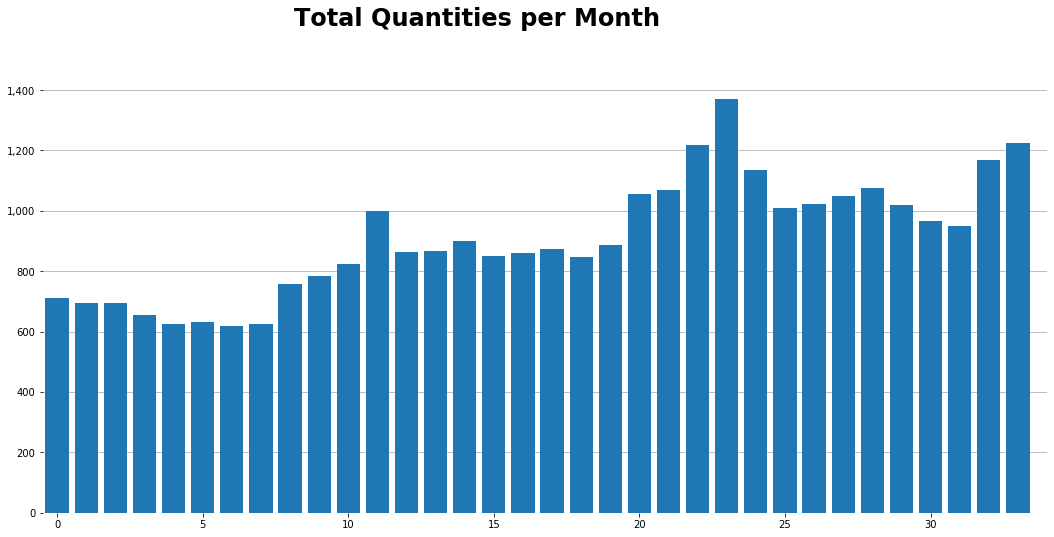

In [22]:
rev_agg = sales_train_ordered.groupby('date_block_num').agg(item_cnt_month = ('item_price','mean'))
fig,  ax = plt.subplots(figsize = (18,8))
ax.bar(rev_agg.index, rev_agg['item_cnt_month'], align='center')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.grid(which= 'major', axis= 'y', linestyle= '-')
ax.set_axisbelow(True)
plt.xlim(-0.5,34)
ax.text(0.25, 1.12, 'Total Quantities per Month',
        transform= ax.transAxes, size= 24, weight= 600, ha= 'left')
plt.box(False);

In [42]:
shops['city'] = [i[1:] if i[0]=='!' else i for i in shops['shop_name']]
shops['city'] = [i.split(' ')[0] for i in shops['city']]
shops['city2'] = ''

shops

,shop_name,shop_id,city,city2
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,
2,"Адыгея ТЦ ""Мега""",2,Адыгея,
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,
6,"Воронеж (Плехановская, 13)",6,Воронеж,
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,
9,Выездная Торговля,9,Выездная,


In [46]:
from googletrans import Translator



In [47]:
city_lst = []

for row in shops['city']:
    translator = Translator()
    translated = translator.translate(row, src= 'ru', dest= 'en')
    row = translated.text
    city_lst.append(row)

In [48]:
city_lst

['Yakutsk',
 'Yakutsk',
 'Adygea',
 'Balashikha',
 'Volzhsky',
 'Vologda',
 'Voronezh',
 'Voronezh',
 'Voronezh',
 'exit',
 'Zhukovsky',
 'Zhukovsky',
 'Shop Online',
 'Kazan',
 'Kazan',
 'Kaluga',
 'Kolomna',
 'Krasnoyarsk',
 'Krasnoyarsk',
 'Kursk',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Moscow',
 'Mytishchi',
 'Nizhny Novgorod',
 'Nizhny Novgorod',
 'Novosibirsk',
 'Novosibirsk',
 'Omsk',
 'Rostov-on-Don',
 'Rostov-on-Don',
 'Rostov-on-Don',
 'SPb',
 'SPb',
 'Samara',
 'Samara',
 'Sergiev',
 'Surgut',
 'Tomsk',
 'Tyumen',
 'Tyumen',
 'Tyumen',
 'Ufa',
 'Ufa',
 'Khimki',
 'Digital',
 'Czechs',
 'Yakutsk',
 'Yakutsk',
 'Yaroslavl']

In [49]:
shops['city2'] = np.array(city_lst)

In [50]:
shops

,shop_name,shop_id,city,city2
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,Yakutsk
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,Yakutsk
2,"Адыгея ТЦ ""Мега""",2,Адыгея,Adygea
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,Balashikha
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,Volzhsky
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,Vologda
6,"Воронеж (Плехановская, 13)",6,Воронеж,Voronezh
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,Voronezh
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,Voronezh
9,Выездная Торговля,9,Выездная,exit


In [51]:
shops.to_csv('shops_translated.csv')

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

In [15]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'revenue'],
      dtype='object')

In [16]:
sales_train['year'] = sales_train.date_block_num.apply(lambda x: ((x//12) + 2013))
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,year
0,2013-01-02,0,59,22154,999.00,1.0,999.00,2013
1,2013-01-03,0,25,2552,899.00,1.0,899.00,2013
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,2013
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,2013
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,2013
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,299.00,2015
2935845,2015-10-09,33,25,7460,299.00,1.0,299.00,2015
2935846,2015-10-14,33,25,7459,349.00,1.0,349.00,2015
2935847,2015-10-22,33,25,7440,299.00,1.0,299.00,2015


In [17]:
sales_train['month'] = sales_train.date_block_num.apply(lambda x: (x % 12))
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,year,month
0,2013-01-02,0,59,22154,999.00,1.0,999.00,2013,0
1,2013-01-03,0,25,2552,899.00,1.0,899.00,2013,0
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,2013,0
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,2013,0
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,2013,0
...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,299.00,2015,9
2935845,2015-10-09,33,25,7460,299.00,1.0,299.00,2015,9
2935846,2015-10-14,33,25,7459,349.00,1.0,349.00,2015,9
2935847,2015-10-22,33,25,7440,299.00,1.0,299.00,2015,9


In [18]:
sales_train['year_dt'] = sales_train.date.dt.year
sales_train['month_dt'] = sales_train.date.dt.month
sales_train['day_dt'] = sales_train.date.dt.day

In [19]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,year,month,year_dt,month_dt,day_dt
0,2013-01-02,0,59,22154,999.00,1.0,999.00,2013,0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,899.00,2013,0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,2013,0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,2013,0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,2013,0,2013,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,299.00,2015,9,2015,10,10
2935845,2015-10-09,33,25,7460,299.00,1.0,299.00,2015,9,2015,10,9
2935846,2015-10-14,33,25,7459,349.00,1.0,349.00,2015,9,2015,10,14
2935847,2015-10-22,33,25,7440,299.00,1.0,299.00,2015,9,2015,10,22
